Dependencies
-

In [1]:
#DFEST & Synthetic Ground Truth Model Dependencies

#sys.path.append('/tmpscratch/skelly26/.local/bin')
#sys.path.append('/tmpscratch/skelly26/.local/lib/python3.8/site-packages')

import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install matplotlib

import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
#from deepctr.models import DeepFM
#from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

import time
import sys

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
#from deepctr.layers import custom_objects

import numpy as np
import math
from collections import deque
import random
import heapq

import scipy

In [2]:
#Additonal LIME Dependencies

#!{sys.executable} -m pip install pyDOE2
#!{sys.executable} -m pip install lime

import warnings
warnings.filterwarnings("ignore")

import collections
import copy
from functools import partial
import json

import scipy as sp
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from pyDOE2 import lhs
from scipy.stats.distributions import norm

import lime
from lime.discretize import QuartileDiscretizer
from lime.discretize import DecileDiscretizer
from lime.discretize import EntropyDiscretizer
from lime.discretize import BaseDiscretizer
from lime.discretize import StatsDiscretizer
from lime import explanation
from lime import lime_base
from lime.lime_tabular import TableDomainMapper
#Omit importing lime_tabular from lime, as the class is modified to accept synth GTI function as input

Define Structure of Feature Space as a Graph
-

In [3]:
class Node:
    def __init__(self, position, distance):
        
        #Position list([row, column])
        self.position = position # [n1, n2, ..., n|N|]
        self.distance = distance #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same distance
    def __eq__(self, other):
        return isinstance(other, Node) and self.distance == other.distance
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.distance < other.distance

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.distance > other.distance

Calculate Feature-Interaction Cluster
-

In [4]:
# Puts solution node into a n-way feature interaction cluster, and tell which cluster
def cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler):
    
    #print("query_node1",query_node.position, "source_node1",source_node.position)
    soln_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
                
    if tuple(soln_cluster) not in solution_clusters:
        solution_clusters[tuple(soln_cluster)] = []

    solution_clusters[tuple(soln_cluster)].append(query_node.position)
    
    return solution_clusters #returns full cluster list


def calc_feat_cluster(source_node, query_node, feat_scaler):
    
    relative_node_pos = (query_node.position - source_node.position) #Projects pos of query relative to source
    scaled_feats = (relative_node_pos * feat_scaler) #[0] #Scales features to same scale of distance
    f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
    soln_cluster = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position
    
    #Loop through each feature of a single solution, and determine degree of multi-feature interaction
    for f_i in range(len(scaled_feats)):
        
        if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
            if scaled_feats[f_i] > 0:
                soln_cluster[f_i] = 1
            else:
                soln_cluster[f_i] = -1
    
    if scaled_feats[f_max] > 0:
        soln_cluster[f_max] = 1
    else:
        soln_cluster[f_max] = -1
        
    return soln_cluster.astype(int)

Define Synthetic Model (Global)
-
Given d-dimensional feature space, the synthetic_model() mathemtatically defines a ground truth decision boundary, such that all points within the bounds of a solution cluster are all a distance r from the source node position

Generate Uniform Distribution of Unit Vectors in d-dimensional space
---

In [5]:
def generate_unit_vectors(nfeats,nvectors=1):

    #np.random.seed(3)
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        #v_hat = v / np.linalg.norm(v)
        vectors.append(v)
    return vectors

Find k-way Feature-Interaction Solutions Surrounding Source Node
---

In [6]:
def generate_precursor_solutions(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=20, nsteps=100):
    
    #plt.rcParams["figure.figsize"] = (10,10)
    
    feat_ranges = feat_ranges #Ground truth altered boundary of solutions
    feat_range = feat_ranges[0] #debug: gti can't dynamically scale feat proportions
    feat_upscale = len(feat_ranges)
    step_sizes = feat_upscale*feat_ranges/nsteps #How large of a step to take for each respective int feature
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance
    
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.linspace(step_sizes[feat],step_sizes[feat]*nsteps,nsteps))
    feat_steps = np.asarray(feat_steps)
    
    source_rec = query_synth_model(source_node, source_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)

    discovered = []

    while len(discovered) < k_prelim:
        
        #print("###########################################################################")
        unit_vector = generate_unit_vectors(len(source_node.position))[0]
        unit_vector = np.sign(np.round(unit_vector)) #Scale randomly generated clusters by appropriate ratio
        for step in range(nsteps-1):
            scaled_vector_position = tuple(np.asarray(unit_vector) * np.asarray(feat_steps.T[step]) + np.asarray(source_node.position))
            #print("         ",scaled_vector_position)
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_synth_model(source_node, scaled_vector, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
            
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'bd',markersize=10)
            
            if source_rec != query_rec:
                # distance heuristic
                #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'r^',markersize=15)
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                if len(discovered) % 10000 == 0:
                    print(len(discovered),end=' ')
                break
                
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=20)
        
    return discovered #prelim_discovered

Calculate Distance from Source to Query Node
---

In [7]:
def get_distance(source_node, query_node, feat_scaler, distance='Euclidean'):
    #returns distance for ndim feature space
    
    dif = query_node.position - source_node.position
    scaled_dif = dif * feat_scaler
    
    # More efficient at scale
    if distance == 'Manhattan':
        return sum(abs(scaled_dif))
    
    if distance == 'Euclidean':
        dsum = 0
        for feat in dif:
            dsum += feat**2
        return math.sqrt(dsum)

Display Shortest Clusters Found During Outside-In Search
-

In [8]:
def sort_solution_clusters(solution_clusters,source_node,feat_scaler):
    
    all_distances = []
    for key in solution_clusters:
        total_distance = []
        for soln in solution_clusters[key]:
            distance = get_distance(source_node, Node(soln,None), feat_scaler)
            total_distance.append(distance)
        all_distances.append(np.sort(total_distance))
        #print(key,':',(solution_clusters[key] * np.asarray(key)).mean())
        
    sorted_clusters = []
    i = 0
    for key in solution_clusters:
        min_sample = all_distances[i].min()
        sorted_clusters.append((min_sample,key))
        i+=1
    
    sorted_clusters = np.asarray(sorted_clusters)
    ind = sorted_clusters.argsort(axis=0)
    sorted_clusters[:,0] = sorted_clusters[:,0][ind[:,0]]
    sorted_clusters[:,1] = sorted_clusters[:,1][ind[:,0]]
    
    return sorted_clusters

---

Adjacent Cluster Search
-

In [9]:
#Return positions in adjacent solution clusters
def find_adjs(source_node, query_node, feat_scaler):
    
    query_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    query_cluster = list(query_cluster)
    adj_clusters = []

    #1-way changes are applied to each feature in the query cluster to generate adj clusters
    source_cluster = tuple(np.zeros(len(query_cluster)))
    for dim in range(len(query_cluster)):
        temp = query_cluster.copy()
        if temp[dim] < 1:
            temp[dim] += 1
            if temp != source_cluster:
                adj_clusters.append(temp)
        temp = query_cluster.copy()
        if temp[dim] > -1:
            temp[dim] -= 1
            if temp != source_cluster:
                adj_clusters.append(temp)

    #Normalization to find x_q
    feat_scaler_distance = 0
    for feat in feat_scaler:
        feat_scaler_distance += feat ** 2
    feat_scaler_distance = feat_scaler_distance ** 0.5
        
    adjs = []
    for cluster in adj_clusters:
        
        # n-dimensional euclidean distance to a point in the adj cluster equivalent to the distance
        # from the original query cluster
        # query_node.distance is pre-scaled scaled
        x_q = source_node.position + feat_scaler * np.asarray(cluster) * query_node.distance / feat_scaler_distance
        adj_node = Node(np.asarray(x_q), query_node.distance)
        adjs.append(adj_node)
        
    return adjs  

A* Cluster Search
-

In [10]:
#A* with solution cluster tracking
def a_star_search(source_node, prelim_discovered, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_astar=100):
    
    #Analytics to inform how to handle degree of branching
    feat_range = feat_ranges[0] #Can't yet use multiple ranges for defining gti
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    solution_clusters = {}
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    #Opposite Recommendation as Solutions
    source_rec = query_synth_model(source_node, source_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    # loop till queue is empty, or k solutions were discovered
    while frontier and len(discovered) < k_astar:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check if query node is a solution
        query_rec = query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
        if query_rec != source_rec:
            
            feat_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
            
            if tuple(feat_cluster) not in solution_clusters.keys():
                
                #Finds shortest distance node in cluster, returns solution_clusters with descending solutions
                solution_clusters, min_node = find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
                discovered.append(min_node) #redundant list
                if len(discovered) % 100 == 0:
                    print(len(discovered),end=' ')
                
                #Add adjacents to priority queue before visiting them
                adjs = find_adjs(source_node, min_node, feat_scaler) #Nodes in clusters adjacent to the current node
                for adj_node in adjs:
                    heapq.heappush(frontier, adj_node)
                    nodes_generated += 1
    
    print("\nNodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)

    return solution_clusters

In [11]:
#Return node with estimated minimum distance from source node
def find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance, nsteps=100):
    
    plt.rcParams["figure.figsize"] = (10, 10)
    relative_pos = query_node.position - source_node.position
    step_sizes = relative_pos/nsteps #How large of a step to take for each respective int feature

    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(relative_pos)):
        if step_sizes[feat] != 0:
            feat_steps.append(np.linspace(step_sizes[feat],relative_pos[feat],nsteps))
        else:
            feat_steps.append(np.zeros(nsteps))
    for feat in feat_steps:
        np.flip(feat)
    feat_steps = np.asarray(feat_steps)    

    source_rec = query_synth_model(source_node, source_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    query_rec = query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    if source_rec != query_rec:
        solution_clusters = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler)
    
    min_node = query_node
    for step in range(nsteps-1):
        
        local_feat_step = []
        for feat in range(len(feat_steps)):
            local_feat_step.append(feat_steps[feat][step])
        scaled_vector_position = tuple(np.asarray(query_node.position) - np.asarray(local_feat_step))
        #scaled_vector_position = np.asarray(source_node.position + local_feat_step)
        scaled_vector = Node(scaled_vector_position, None)
        query_rec = query_synth_model(source_node, scaled_vector, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
        
        if source_rec == query_rec:
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'g*',markersize=15)
            break
            
        scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
        min_node = scaled_vector
        solution_clusters = cluster_feat_int(source_node, min_node, solution_clusters, feat_scaler)
        #print(min_node.position,end='')

        #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'m+',markersize=10)
        
    #print(calc_feat_cluster(source_node, min_node, feat_scaler))
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=30)

    return solution_clusters, min_node

Test on Higher Dimensional Feature Space
-

In [12]:
#Individual Features with Greater Sway on the Alternate Rec Distance
def generate_continuous_gti(gti_min_cluster, feat_range, kclusters, d_dims, gti_feature_importance):
    
    #Define shortest feat cluster to build a stability descent around
    min_cluster_node = gti_min_cluster
    source_cluster = tuple(np.zeros(d_dims)) #censor in generated clusters

    frontier = []
    visited = []
    heapq.heappush(frontier, min_cluster_node)

    #Build stability descent around min_node
    i = 0
    ground_truth_importance = {}
    while frontier and i < kclusters:

        cur = heapq.heappop(frontier)
        if cur.position not in ground_truth_importance.keys():
            ground_truth_importance[cur.position] = cur.distance
            i+=1

            for dim in range(d_dims):
                temp = list(cur.position)
                if temp[dim] < 1:
                    temp[dim] += 1
                    temp = tuple(temp)
                    if temp != source_cluster and temp not in visited:
                        adj_node = Node(temp, None)
                        adj_node.distance = synth_cluster_distance_generator(min_cluster_node, adj_node, feat_range, gti_feature_importance)
                        heapq.heappush(frontier, adj_node)
                        visited.append(temp)
                
                #Don't include negative permutations because distances are the same
                temp = list(cur.position)
                if temp[dim] > -1:
                    temp[dim] -= 1
                    temp = tuple(temp)
                    if temp != source_cluster and temp not in visited:
                        adj_node = Node(temp, None)
                        adj_node.distance = synth_cluster_distance_generator(min_cluster_node, adj_node, feat_range, gti_feature_importance)
                        adj_node.distance += adj_node.distance
                        heapq.heappush(frontier, adj_node)
                        visited.append(temp)
    
    return ground_truth_importance #Returns top k gti feature-interactions


def get_synth_cluster_block_distance(min_cluster_node, query_cluster_node, gti_feature_importance):
    #Distance of cur to min_node, used to make cur proportionately larger
    block_distance = 0
    for feat in range(len(min_cluster_node.position)):
        feat_block_distance = abs(min_cluster_node.position[feat] - query_cluster_node.position[feat])
        block_distance += feat_block_distance * gti_feature_importance[feat]
    return block_distance

#Returns distance of cluster in feature space
def synth_cluster_distance_generator(min_cluster_node, query_cluster_node, feat_range, gti_feature_importance):
    
    block_distance = get_synth_cluster_block_distance(min_cluster_node, query_cluster_node, gti_feature_importance)
    increment = min_cluster_node.distance / (max(gti_feature_importance) / 10) # decision boundary will be within feat range
    return min_cluster_node.distance + block_distance * increment

#Non-linear synethetic model
#Decision boundary dynamically generated based on closest solutions and feature importance multipliers
def query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster, gti_feature_importance):
    
    #Determine cluster of query_node
    cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    relative_position = query_node.position - source_node.position
    
    # create n feature hyper-arc specific to cluster
    distance = 0
    for term in relative_position:
        distance += abs(term) ** 2
    distance = distance ** 0.5
    
    decision_threshold = synth_cluster_distance_generator(gti_min_cluster, Node(cluster,None), feat_range, gti_feature_importance)
        
    if distance < decision_threshold:
        return 0
    else:
        return 1

In [13]:
#Run A* against ground truth synthetic model

def gd_fits(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=100, k_astar=100):

    plt.rcParams["figure.figsize"] = (40,15)
    
    feat_scaler = 1/np.asarray(feat_ranges)

    start_time = time.time()
    prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, nsteps=4, k_prelim=k_prelim)
    print("\n\nPreliminary Search Time:", time.time()-start_time,'seconds')
    
    start_time = time.time()
    solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_astar=k_astar)
    print("\n\nA* Cluster Search Time:", time.time()-start_time,'seconds')

    sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
    #display_instability(sorted_clusters)

    return sorted_clusters

---


LimeTabularExplainer with Synthetic GTI Model
-

In [14]:
class LimeTabularExplainer_synth(object):

    def __init__(self,
                 training_data,
                 mode="classification",
                 training_labels=None,
                 feature_names=None,
                 categorical_features=None,
                 categorical_names=None,
                 kernel_width=None,
                 kernel=None,
                 verbose=False,
                 class_names=None,
                 feature_selection='auto',
                 discretize_continuous=True,
                 discretizer='quartile',
                 sample_around_instance=False,
                 random_state=None,
                 training_data_stats=None):

        self.random_state = check_random_state(random_state)
        self.mode = mode
        self.categorical_names = categorical_names or {}
        self.sample_around_instance = sample_around_instance
        self.training_data_stats = training_data_stats

        # Check and raise proper error in stats are supplied in non-descritized path
        if self.training_data_stats:
            self.validate_training_data_stats(self.training_data_stats)

        if categorical_features is None:
            categorical_features = []
        if feature_names is None:
            feature_names = [str(i) for i in range(training_data.shape[1])]

        self.categorical_features = list(categorical_features)
        self.feature_names = list(feature_names)

        self.discretizer = None
        if discretize_continuous and not sp.sparse.issparse(training_data):
            # Set the discretizer if training data stats are provided
            if self.training_data_stats:
                discretizer = StatsDiscretizer(
                    training_data, self.categorical_features,
                    self.feature_names, labels=training_labels,
                    data_stats=self.training_data_stats,
                    random_state=self.random_state)

            if discretizer == 'quartile':
                self.discretizer = QuartileDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif discretizer == 'decile':
                self.discretizer = DecileDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif discretizer == 'entropy':
                self.discretizer = EntropyDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif isinstance(discretizer, BaseDiscretizer):
                self.discretizer = discretizer
            else:
                raise ValueError('''Discretizer must be 'quartile',''' +
                                 ''' 'decile', 'entropy' or a''' +
                                 ''' BaseDiscretizer instance''')
            self.categorical_features = list(range(training_data.shape[1]))

            # Get the discretized_training_data when the stats are not provided
            if(self.training_data_stats is None):
                discretized_training_data = self.discretizer.discretize(
                    training_data)

        if kernel_width is None:
            kernel_width = np.sqrt(training_data.shape[1]) * .75
        kernel_width = float(kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.feature_selection = feature_selection
        self.base = lime_base.LimeBase(kernel_fn, verbose, random_state=self.random_state)
        self.class_names = class_names

        # Though set has no role to play if training data stats are provided
        self.scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
        self.scaler.fit(training_data)
        self.feature_values = {}
        self.feature_frequencies = {}

        for feature in self.categorical_features:
            if training_data_stats is None:
                if self.discretizer is not None:
                    column = discretized_training_data[:, feature]
                else:
                    column = training_data[:, feature]

                feature_count = collections.Counter(column)
                values, frequencies = map(list, zip(*(sorted(feature_count.items()))))
            else:
                values = training_data_stats["feature_values"][feature]
                frequencies = training_data_stats["feature_frequencies"][feature]

            self.feature_values[feature] = values
            self.feature_frequencies[feature] = (np.array(frequencies) /
                                                 float(sum(frequencies)))
            self.scaler.mean_[feature] = 0
            self.scaler.scale_[feature] = 1

    @staticmethod
    def convert_and_round(values):
        return ['%.2f' % v for v in values]

    @staticmethod
    def validate_training_data_stats(training_data_stats):
        """
            Method to validate the structure of training data stats
        """
        stat_keys = list(training_data_stats.keys())
        valid_stat_keys = ["means", "mins", "maxs", "stds", "feature_values", "feature_frequencies"]
        missing_keys = list(set(valid_stat_keys) - set(stat_keys))
        if len(missing_keys) > 0:
            raise Exception("Missing keys in training_data_stats. Details: %s" % (missing_keys))

##########################################################################################################
    def explain_instance_synth(self,
                         data_row,
                         gti_params,
                         labels=(1,),
                         top_labels=None,
                         num_features=10,
                         num_samples=5000,
                         distance_metric='euclidean',
                         model_regressor=None,
                         sampling_method='gaussian'):
        
        #Perturbate neighborhood of data points surrounding original model input
        if sp.sparse.issparse(data_row) and not sp.sparse.isspmatrix_csr(data_row):
            # Preventative code: if sparse, convert to csr format if not in csr format already
            data_row = data_row.tocsr()
        data, inverse = self.__data_inverse(data_row, num_samples, sampling_method)
        if sp.sparse.issparse(data):
            # Note in sparse case we don't subtract mean since data would become dense
            scaled_data = data.multiply(self.scaler.scale_)
            # Multiplying with csr matrix can return a coo sparse matrix
            if not sp.sparse.isspmatrix_csr(scaled_data):
                scaled_data = scaled_data.tocsr()
        else:
            scaled_data = (data - self.scaler.mean_) / self.scaler.scale_
        distances = sklearn.metrics.pairwise_distances(
                scaled_data,
                scaled_data[0].reshape(1, -1),
                metric=distance_metric
        ).ravel()

        
        #Produce labels for the neighborhood of data points surrounding original model input using synthetic ground truth model
        (gti_min_cluster_node, gti_feature_importance, feat_scaler, feat_range) = gti_params
        source_node = Node(data_row, None)
        yss = []
        for sample in inverse:
            query_node = Node(sample,None)
            rec = query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
            yss.append([1 - rec, rec])
        yss = np.asarray(yss) 
            
        feature_names = copy.deepcopy(self.feature_names)
        if feature_names is None:
            feature_names = [str(x) for x in range(data_row.shape[0])]

        if sp.sparse.issparse(data_row):
            values = self.convert_and_round(data_row.data)
            feature_indexes = data_row.indices
        else:
            values = self.convert_and_round(data_row)
            feature_indexes = None

        for i in self.categorical_features:
            if self.discretizer is not None and i in self.discretizer.lambdas:
                continue
            name = int(data_row[i])
            if i in self.categorical_names:
                name = self.categorical_names[i][name]
            feature_names[i] = '%s=%s' % (feature_names[i], name)
            values[i] = 'True'
        categorical_features = self.categorical_features

        discretized_feature_names = None
        if self.discretizer is not None:
            categorical_features = range(data.shape[1])
            discretized_instance = self.discretizer.discretize(data_row)
            discretized_feature_names = copy.deepcopy(feature_names)
            for f in self.discretizer.names:
                discretized_feature_names[f] = self.discretizer.names[f][int(
                        discretized_instance[f])]

        domain_mapper = TableDomainMapper(feature_names,
                                          values,
                                          scaled_data[0],
                                          categorical_features=categorical_features,
                                          discretized_feature_names=discretized_feature_names,
                                          feature_indexes=feature_indexes)
        ret_exp = lime.explanation.Explanation(domain_mapper,
                                          mode=self.mode,
                                          class_names=self.class_names)
        
##########################################################################################################
        
        ######Terminology#######
        
        # LimeTabular    explain_instance_with_data
        
        # scaled_data:   neighborhood_data:     perturbed data, 1st is original point to explain
        # yss:           neighborhood_labels:   labels corresponding to perturbed data
        # distances:     distances:             distances to original data point
        # label:         label:                 label to explain
        # num_features:  num_features:          max number of features to explain
    
        #self.mode == "classification":
        ret_exp.predict_proba = yss[0]
        if top_labels:
            labels = np.argsort(yss[0])[-top_labels:]
            ret_exp.top_labels = list(labels)
            ret_exp.top_labels.reverse()
        
        ret_exp.score = {}
        ret_exp.local_pred = {}
         
        for label in labels:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score[label],
             ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                    scaled_data,
                    yss,
                    distances,
                    label,
                    num_features)


        return ret_exp

    def __data_inverse(self,
                       data_row,
                       num_samples,
                       sampling_method):
       
        is_sparse = sp.sparse.issparse(data_row)
        if is_sparse:
            num_cols = data_row.shape[1]
            data = sp.sparse.csr_matrix((num_samples, num_cols), dtype=data_row.dtype)
        else:
            num_cols = data_row.shape[0]
            data = np.zeros((num_samples, num_cols))
        categorical_features = range(num_cols)
        if self.discretizer is None:
            instance_sample = data_row
            scale = self.scaler.scale_
            mean = self.scaler.mean_
            if is_sparse:
                # Perturb only the non-zero values
                non_zero_indexes = data_row.nonzero()[1]
                num_cols = len(non_zero_indexes)
                instance_sample = data_row[:, non_zero_indexes]
                scale = scale[non_zero_indexes]
                mean = mean[non_zero_indexes]

            if sampling_method == 'gaussian':
                data = self.random_state.normal(0, 1, num_samples * num_cols
                                                ).reshape(num_samples, num_cols)
                data = np.array(data)
            elif sampling_method == 'lhs':
                data = lhs(num_cols, samples=num_samples
                           ).reshape(num_samples, num_cols)
                means = np.zeros(num_cols)
                stdvs = np.array([1]*num_cols)
                for i in range(num_cols):
                    data[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(data[:, i])
                data = np.array(data)
            else:
                warnings.warn('''Invalid input for sampling_method.
                                 Defaulting to Gaussian sampling.''', UserWarning)
                data = self.random_state.normal(0, 1, num_samples * num_cols
                                                ).reshape(num_samples, num_cols)
                data = np.array(data)

            if self.sample_around_instance:
                data = data * scale + instance_sample
            else:
                data = data * scale + mean
            if is_sparse:
                if num_cols == 0:
                    data = sp.sparse.csr_matrix((num_samples,
                                                 data_row.shape[1]),
                                                dtype=data_row.dtype)
                else:
                    indexes = np.tile(non_zero_indexes, num_samples)
                    indptr = np.array(
                        range(0, len(non_zero_indexes) * (num_samples + 1),
                              len(non_zero_indexes)))
                    data_1d_shape = data.shape[0] * data.shape[1]
                    data_1d = data.reshape(data_1d_shape)
                    data = sp.sparse.csr_matrix(
                        (data_1d, indexes, indptr),
                        shape=(num_samples, data_row.shape[1]))
            categorical_features = self.categorical_features
            first_row = data_row
        else:
            first_row = self.discretizer.discretize(data_row)
        data[0] = data_row.copy()
        inverse = data.copy()
        for column in categorical_features:
            values = self.feature_values[column]
            freqs = self.feature_frequencies[column]
            inverse_column = self.random_state.choice(values, size=num_samples,
                                                      replace=True, p=freqs)
            binary_column = (inverse_column == first_row[column]).astype(int)
            binary_column[0] = 1
            inverse_column[0] = data[0, column]
            data[:, column] = binary_column
            inverse[:, column] = inverse_column
        if self.discretizer is not None:
            inverse[1:] = self.discretizer.undiscretize(inverse[1:])
        inverse[0] = data_row
        return data, inverse

Feature Importance Ranking Loss Function
-

In [15]:
def calc_ranking_loss(ktop_gti, query_clusters, d_dims):

    loss = 0
    for gti_cluster in range(len(ktop_gti)):

        min_loss = math.inf
        for q_cluster in range(len(query_clusters)):

            #Penalize difference in ranking position
            ranking_loss = abs(gti_cluster - q_cluster)
            #print(ranking_loss)

            #Penalize difference in cluster composition
            cluster_loss = 0
            for feat in range(len(list(ktop_gti)[gti_cluster])):
                cluster_loss += abs(list(ktop_gti)[gti_cluster][feat] - list(query_clusters)[q_cluster][feat])
            temp_loss = (1 + ranking_loss) * (1 + cluster_loss)

            if temp_loss < min_loss:
                min_loss = temp_loss

        loss += min_loss - 1

    regularized_loss = loss / d_dims / len(ktop_gti)
    
    return regularized_loss

Intialize Synthetic Ground Truth Importance Model
-

In [74]:
np.random.seed(seed=0)
d_dims = 64
source_node = Node(np.zeros(d_dims),0) #Want to explain this value
k_clusters = 8 #Number of sub-maximum decision boundaries generated in ground_truth_importance

feat_ranges = np.zeros(d_dims) + 100 #Assume all features have range 1000
feat_range = feat_ranges[0]
feat_scaler = 1 / feat_ranges

min_cluster = tuple(np.zeros(d_dims))
while min_cluster == tuple(np.zeros(d_dims)):
    min_cluster = tuple(np.random.randint(low=-1,high=2, size=d_dims)) # Can make small set of these
gti_min_cluster_node = Node(min_cluster,feat_range * 0.3)

gti_feature_importance = np.arange(1,len(min_cluster)*2,2)
np.random.shuffle(gti_feature_importance)

print("min_cluster",min_cluster)
print("feature_importance",gti_feature_importance)

ground_truth_importance = {}
ground_truth_importance = generate_continuous_gti(gti_min_cluster_node, feat_range, k_clusters, d_dims, gti_feature_importance)
#print("ground_truth_importance",ground_truth_importance)

min_cluster (-1, 0, -1, 0, 0, 1, -1, 1, -1, -1, -1, 1, 0, 1, 1, -1, 0, 0, 0, 0, -1, 0, -1, -1, 0, 1, -1, 1, -1, 0, 0, 1, -1, 0, 0, 0, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 0, 0, 1, -1, -1, 0, -1, 0, 1, 1, -1, 0, 0, 0, 0, 1, 1, 1)
feature_importance [ 59  67  91   3  57  17 105  93  45  51  97  39  49  77  87  65 109  83
  69  19  15  53  79  21 127  99  33   5 103  37  35 101  61  75  63 125
 113  11  43  27  89  47 121 111  31 123  81  73 117   7  95 119  13   9
  23  41  85 115  25 107  71  29   1  55]


Evaluation of DFEST 
-

In [73]:
sorted_clusters = gd_fits(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=10000, k_astar=5000)
i=0
ktop_sorted_clusters = []
for soln in sorted_clusters:
    if i >= k_clusters:
        break
    ktop_sorted_clusters.append(soln)
    i+=1
sorted_solution_clusters = {}
for cluster in ktop_sorted_clusters:
    sorted_solution_clusters[cluster[1]] = cluster[0]
dfest_loss = calc_ranking_loss(ground_truth_importance, sorted_solution_clusters, d_dims)
print("DFEST Loss:",dfest_loss)

#Random Chance Evaluation
random_gti = {}
while len(random_gti) < k_clusters: #len(solution_clusters):
    random_cluster = tuple(np.random.randint(low=-1,high=2, size=d_dims)) 
    if random_cluster not in random_gti.keys():
        random_gti[random_cluster] = np.random.randint(low=0,high=feat_range)
random_loss = calc_ranking_loss(ground_truth_importance, random_gti, d_dims)
print("Random Loss:",random_loss)

#Self Evaluation
self_loss = calc_ranking_loss(ground_truth_importance, ground_truth_importance, d_dims)
print("Self Loss:",self_loss)

10000 

Preliminary Search Time: 3.7442009449005127 seconds
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 
Nodes Visited: 254558
Nodes Generated: 259606


A* Cluster Search Time: 76.4768922328949 seconds
DFEST Loss: 0.49609375
Random Loss: 0.875
Self Loss: 0.0


In [71]:
sorted_solution_clusters

{(-1,
  0,
  -1,
  0,
  0,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  -1,
  -1,
  0,
  1,
  -1,
  1,
  1,
  0,
  0,
  0): 1472.0,
 (-1,
  0,
  0,
  0,
  -1,
  0,
  0,
  1,
  -1,
  1,
  -1,
  1,
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  0,
  1,
  -1,
  1,
  -1,
  0,
  0,
  0): 1676.2625092747257,
 (-1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  1,
  0,
  0,
  1,
  -1,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  0,
  0,
  -1,
  1,
  -1,
  0,
  0,
  0): 1795.995545651492,
 (-1,
  0,
  -1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  -1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  -1,
  1,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  1,
  0,
  0,
  0,
  1): 1797.0642726402414,
 (-1,
  0,
  -1,
  0,
  1,
  1,
  -1,
  1,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  0,
  0,
  -1,
  1,
  1): 1847.1513202767119,
 (-1,
  0,
  0,
  -1,
  0,
  1,
  -1,
  1,
  0,
  0,
  -1,
  0

In [72]:
ground_truth_importance

{(-1,
  0,
  -1,
  0,
  0,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  0,
  1,
  1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  1,
  -1,
  1,
  -1,
  0,
  0,
  1): 30.0,
 (-1,
  0,
  -1,
  0,
  0,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  0,
  1,
  1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  1,
  -1,
  1,
  -1,
  0,
  1,
  1): 34.76190476190476,
 (-1,
  0,
  -1,
  0,
  0,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  0,
  1,
  1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  1,
  -1,
  1,
  -1,
  1,
  0,
  1): 44.285714285714285,
 (-1,
  0,
  -1,
  0,
  0,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  0,
  1,
  1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  1,
  -1,
  1,
  -1,
  1,
  1,
  1): 49.04761904761905,
 (-1,
  0,
  -1,
  0,
  0,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  0,
  1,
  1,
  -1,
  0,
  0,
  0,
  1,
  -1,
  0,
  -1,
  -1,
  0,
  1,
  -1,
  1,
  -1,
  0,
  0,
  1): 53.80952380952381,
 (-1,
  0,
  -1,
  0,
  0,
  1,
  -1,
  1,
  -1,
  -

Preprocess GTI For LIME
-

In [116]:
gti_params = (gti_min_cluster_node, gti_feature_importance, feat_scaler, feat_range)
synth_target_names = np.asarray(["Class 1","Class 2"],dtype='<U9')
synth_feature_names = np.asarray(['f'+str(i) for i in range(d_dims)], dtype='<U23')

#Generate "training data" for LIME input
feat_range = feat_ranges[0]
synth_data = []
synth_labels = []
nsamp = 10000
for _ in range(nsamp):
    point = np.random.uniform(low=-1*feat_range*5, high=1*feat_range*5, size=(d_dims,))
    query_node = Node(point, None)
    rec = query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    synth_data.append(point)
    synth_labels.append(rec)
    
synth_data = np.asarray(synth_data)
synth_labels = np.asarray(synth_labels)
print("synth_data:",synth_data.shape)
print("synth_labels:",synth_labels.shape)

synth_data: (10000, 32)
synth_labels: (10000,)


Evaluation of LIME
-

In [117]:
explainer = LimeTabularExplainer_synth(synth_data, mode="classification",
                                      class_names=synth_target_names,
                                      feature_names=synth_feature_names,)

start_time = time.time()
explanation_response = explainer.explain_instance_synth(source_node.position, gti_params, num_features=d_dims)
print("LIME Explaination Time:",time.time() - start_time)

#Cast LIME Rankings to same format as DFEST, GTI, & Random
LIME_exp_ranking = explanation_response.as_map()
LIME_ranking = {}
synth_feature_names = np.eye(d_dims)[np.arange(d_dims)]
for feature in LIME_exp_ranking[1]:
    LIME_ranking[tuple(synth_feature_names[feature[0]].astype(int))] = abs(feature[1])
    
lime_loss = calc_ranking_loss(ground_truth_importance, LIME_ranking, d_dims)
print("LIME Loss:",lime_loss)

LIME Explaination Time: 14.349501848220825
LIME Loss: 0.671875


In [ ]:
for key in ground_truth_importance:
    print(ground_truth_importance[key])

In [270]:
gti = generate_continuous_gti(gti_min_cluster_node, feat_range, 500, d_dims, gti_feature_importance)
for key in gti:
    print(gti[key])

300.0
323.62204724409446
347.244094488189
370.8661417322835
370.8661417322835
394.48818897637796
394.48818897637796
418.1102362204724
418.1102362204724
418.1102362204724
441.73228346456693
465.35433070866145
465.35433070866145
488.9763779527559
488.9763779527559
488.9763779527559
512.5984251968504
512.5984251968504
512.5984251968504
512.5984251968504
512.5984251968504
536.2204724409448
536.2204724409448
536.2204724409448
536.2204724409448
536.2204724409448
536.2204724409448
536.2204724409448
559.8425196850394
559.8425196850394
559.8425196850394
559.8425196850394
559.8425196850394
559.8425196850394
583.4645669291339
583.4645669291339
583.4645669291339
583.4645669291339
583.4645669291339
583.4645669291339
583.4645669291339
583.4645669291339
583.4645669291339
607.0866141732283
607.0866141732283
607.0866141732283
607.0866141732283
607.0866141732283
607.0866141732283
607.0866141732283
607.0866141732283
607.0866141732283
630.7086614173229
630.7086614173229
630.7086614173229
630.7086614173229

Eval 4C: DFEST, Unifrom Search as a Function of k
---

In [62]:
np.random.seed(seed=0)
d_dims = 32
source_node = Node(np.zeros(d_dims),0) #Want to explain this value
k_clusters = 8 #Number of sub-maximum decision boundaries generated in ground_truth_importance

feat_ranges = np.zeros(d_dims) + 1000 #Assume all features have range 1000
feat_range = feat_ranges[0]
feat_scaler = 1 / feat_ranges

min_cluster = tuple(np.zeros(d_dims))
while min_cluster == tuple(np.zeros(d_dims)):
    min_cluster = tuple(np.random.randint(low=-1,high=2, size=d_dims)) # Can make small set of these
gti_min_cluster_node = Node(min_cluster,feat_range * 0.3)

gti_feature_importance = np.arange(1,len(min_cluster)*2,2)
np.random.shuffle(gti_feature_importance)

print("min_cluster",min_cluster)
print("feature_importance",gti_feature_importance)

ground_truth_importance = {}
ground_truth_importance = generate_continuous_gti(gti_min_cluster_node, feat_range, k_clusters, d_dims, gti_feature_importance)
#print("ground_truth_importance",ground_truth_importance)

min_cluster (-1, 0, -1, 0, 0, 1, -1, 1, -1, -1, -1, 1, 0, 1, 1, -1, 0, 0, 0, 0, -1, 0, -1, -1, 0, 1, -1, 1, -1, 0, 0, 1)
feature_importance [35 57 39 45 29 27 63 55 25 43 59 33 17 13 31 11  9 49 53  5 37 23  7 47
 41 21 61 51 19  3  1 15]


In [55]:
k_solns = np.arange(500,5000,500)
loss_vals = []
for k in k_solns:
    sorted_clusters = gd_fits(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=1000, k_astar=k)
    i=0
    ktop_sorted_clusters = []
    for soln in sorted_clusters:
        if i >= k_clusters:
            break
        ktop_sorted_clusters.append(soln)
        i+=1
    sorted_solution_clusters = {}
    for cluster in ktop_sorted_clusters:
        sorted_solution_clusters[cluster[1]] = cluster[0]
    dfest_loss = calc_ranking_loss(ground_truth_importance, sorted_solution_clusters, d_dims)
    print("DFEST Loss:",dfest_loss)
    loss_vals.append(dfest_loss)



Preliminary Search Time: 0.38438916206359863 seconds


KeyboardInterrupt: 

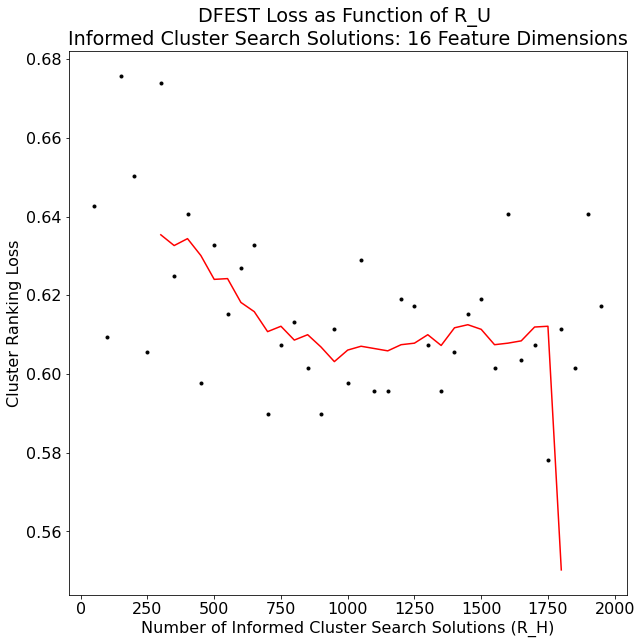

In [53]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')


plt.rcParams.update({'font.size': 16})
plt.title("DFEST Loss as Function of R_U \nInformed Cluster Search Solutions: 32 Feature Dimensions")
plt.xlabel('Number of Informed Cluster Search Solutions (R_H)') 
plt.ylabel('Cluster Ranking Loss') 

plt.plot(k_solns,loss_vals,"k.")
loss_vals_av = movingaverage(loss_vals, 10)
plt.plot(k_solns[5:-3], loss_vals_av[5:-3],"r")

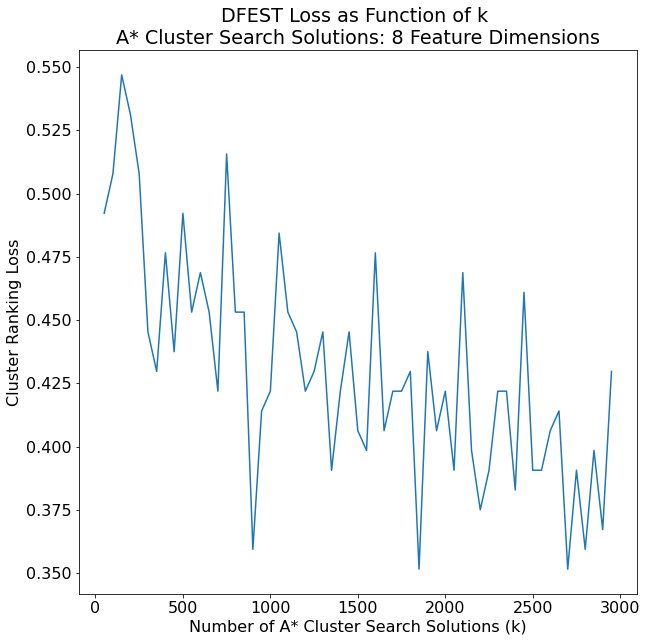

In [470]:
plt.rcParams.update({'font.size': 16})
plt.title("DFEST Loss as Function of k \nInformed Cluster Search Solutions: 8 Feature Dimensions")
plt.xlabel('Number of A* Cluster Search Solutions (k)') 
plt.ylabel('Cluster Ranking Loss') 
plt.plot(k_solns, loss_vals)

In [47]:
k_solns = np.arange(100,10000,100)
loss_vals = []
for k in k_solns:
    sorted_clusters = gd_fits(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=k, k_astar=100)
    i=0
    ktop_sorted_clusters = []
    for soln in sorted_clusters:
        if i >= k_clusters:
            break
        ktop_sorted_clusters.append(soln)
        i+=1
    sorted_solution_clusters = {}
    for cluster in ktop_sorted_clusters:
        sorted_solution_clusters[cluster[1]] = cluster[0]
    dfest_loss = calc_ranking_loss(ground_truth_importance, sorted_solution_clusters, d_dims)
    print("DFEST Loss:",dfest_loss)
    loss_vals.append(dfest_loss)



Preliminary Search Time: 0.037078857421875 seconds
100 
Nodes Visited: 4858
Nodes Generated: 4899


A* Cluster Search Time: 1.6115126609802246 seconds
DFEST Loss: 0.625


Preliminary Search Time: 0.0753946304321289 seconds
100 
Nodes Visited: 5059
Nodes Generated: 5207


A* Cluster Search Time: 1.5410881042480469 seconds
DFEST Loss: 0.6796875


Preliminary Search Time: 0.10439586639404297 seconds
100 
Nodes Visited: 5118
Nodes Generated: 5368


A* Cluster Search Time: 1.6025009155273438 seconds
DFEST Loss: 0.6484375


Preliminary Search Time: 0.12084388732910156 seconds
100 
Nodes Visited: 5057
Nodes Generated: 5408


A* Cluster Search Time: 1.5215003490447998 seconds
DFEST Loss: 0.57421875


Preliminary Search Time: 0.2063589096069336 seconds
100 
Nodes Visited: 5066
Nodes Generated: 5517


A* Cluster Search Time: 1.446415901184082 seconds
DFEST Loss: 0.5859375


Preliminary Search Time: 0.2643730640411377 seconds
100 
Nodes Visited: 5005
Nodes Generated: 5557


A* Cluster Search Ti



Preliminary Search Time: 1.5631089210510254 seconds
100 
Nodes Visited: 4979
Nodes Generated: 9754


A* Cluster Search Time: 1.2091012001037598 seconds
DFEST Loss: 0.52734375


Preliminary Search Time: 1.579746961593628 seconds
100 
Nodes Visited: 4967
Nodes Generated: 9849


A* Cluster Search Time: 1.18192720413208 seconds
DFEST Loss: 0.54296875


Preliminary Search Time: 1.8352739810943604 seconds
100 
Nodes Visited: 4933
Nodes Generated: 9977


A* Cluster Search Time: 1.0516679286956787 seconds
DFEST Loss: 0.51953125


Preliminary Search Time: 1.5560798645019531 seconds
100 
Nodes Visited: 5025
Nodes Generated: 10073


A* Cluster Search Time: 0.9969968795776367 seconds
DFEST Loss: 0.484375


Preliminary Search Time: 1.5942070484161377 seconds
100 
Nodes Visited: 5028
Nodes Generated: 10176


A* Cluster Search Time: 1.0055549144744873 seconds
DFEST Loss: 0.5078125


Preliminary Search Time: 1.7609422206878662 seconds
100 
Nodes Visited: 4988
Nodes Generated: 10286


A* Cluster Sear

KeyboardInterrupt: 

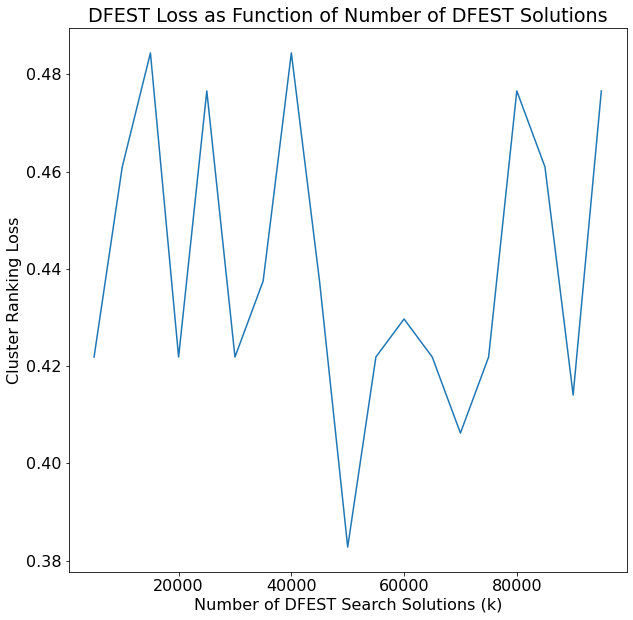

In [468]:
plt.plot(k_solns, loss_vals)
plt.title("DFEST Loss as Function of Number of DFEST Solutions")
plt.xlabel('Number of DFEST Search Solutions (k)') 
plt.ylabel('Cluster Ranking Loss') 
plt.locator_params(axis='x', nbins=6)

-----

In [63]:
#Run A* against ground truth synthetic model
def gd_fits_pre_rep(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, prelim_discovered, k_astar=100):

    plt.rcParams["figure.figsize"] = (40,15)
    
    feat_scaler = 1/np.asarray(feat_ranges)
    
    start_time = time.time()
    solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_astar=k_astar)
    print("\n\nA* Cluster Search Time:", time.time()-start_time,'seconds')

    sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
    #display_instability(sorted_clusters)

    return sorted_clusters


k_prelim=1000000
start_time = time.time()
prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, nsteps=4, k_prelim=k_prelim)
print("\n\nPreliminary Search Time:", time.time()-start_time,'seconds')

k_solns = np.arange(1000,30000,1000)
loss_vals = []
for k in k_solns:
    sorted_clusters = gd_fits_pre_rep(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, prelim_discovered, k_astar=k)
    i=0
    ktop_sorted_clusters = []
    for soln in sorted_clusters:
        if i >= k_clusters:
            break
        ktop_sorted_clusters.append(soln)
        i+=1
    sorted_solution_clusters = {}
    for cluster in ktop_sorted_clusters:
        sorted_solution_clusters[cluster[1]] = cluster[0]
    dfest_loss = calc_ranking_loss(ground_truth_importance, sorted_solution_clusters, d_dims)
    print("DFEST Loss:",dfest_loss)
    loss_vals.append(dfest_loss)

10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000 490000 500000 510000 520000 530000 540000 550000 560000 570000 580000 590000 600000 610000 620000 630000 640000 650000 660000 670000 680000 690000 700000 710000 720000 730000 740000 750000 760000 770000 780000 790000 800000 810000 820000 830000 840000 850000 860000 870000 880000 890000 900000 910000 920000 930000 940000 950000 960000 970000 980000 990000 1000000 

Preliminary Search Time: 325.8013858795166 seconds
100 200 300 400 500 600 700 800 900 1000 
Nodes Visited: 53584
Nodes Generated: 1052636


A* Cluster Search Time: 11.960355281829834 seconds
DFEST Loss: 0.45703125
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 
Nodes Visited: 765998
Nodes Generated: 1751047


A* Cluster Search Time: 155.27727389335632 seconds
DFEST Loss: 0.39453125
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 190

KeyboardInterrupt: 